# WDK-VENUS  v0.1
## Improvements to VENUS
1. Fixed the problem that the original VENUS simulation could not be executed when high rovibrational states of diatomic molecules were specified;
2. Added the ability to test bmax automatically;
3. Improved the process of using VENUS to make it easier to use (triatomic systems only);
4. Added Python scripts for fast processing of VENUS output files;
## External program
5. Automatic sampling of initial conditions;
6. Auto- patch points based on the uncertainties of the predicted values;
7. The python program can directly call matlab to fit the GPR model and predict the ICS values for the initial conditions of the test set;
8. Fast handling of KL divergence between different predictions;
9. Rate coefficients can be calculated for specified vibrational, rotational, and translational temperatures.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math
import random
import matlab.engine
from smt.sampling_methods import LHS
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.cm as cm

(282, 3)


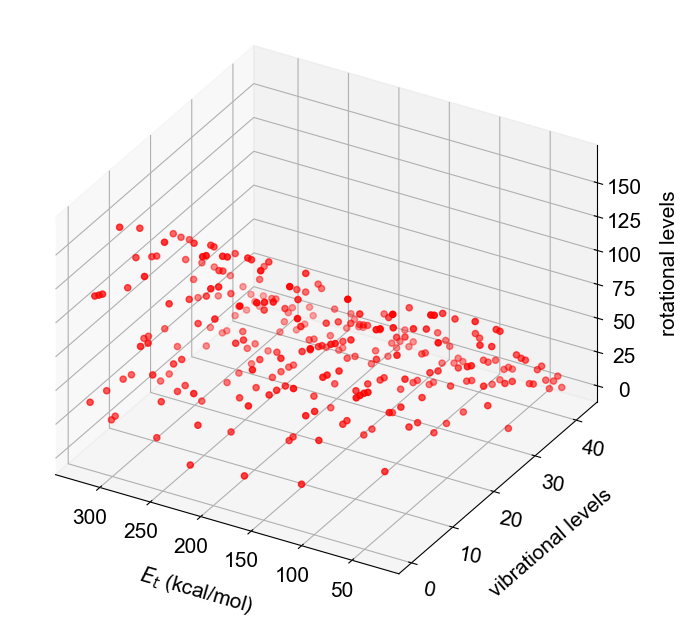

In [2]:
#LHS sample
#######################################################################################
#######################################################################################
####                                                                               ####
####                    LHS sample fix vibrational quantum number                  ####
####                                                                               ####
#######################################################################################
#######################################################################################

# read data
data = pd.read_csv('O2-NJ.csv')

# a new list
all_results = []

# input the max v
n_num = int(input("Please enter the maximum vibrational quantum number: "))

for n in range(n_num+1):
    k = str(n)
    m = data.loc[:, k].dropna()
    j_max = m.shape[0]

    xlimits = np.array([[0.5, 345.9], [0, j_max]])
    sampling = LHS(xlimits=xlimits)

    num = 7
    x = sampling(num)
    x[:, 1] = np.around(x[:, 1]).astype(int)
    N = x[:, 1]

    EN_kcal = np.array([m.iloc[int(n)] for n in N])
    x = np.concatenate((x, np.expand_dims(EN_kcal, axis=1)), axis=1)
    x = np.insert(x, 1, n, axis=1)

    new_x = []
    for i in range(num):
        r_Et = random.random()
        x[i, 0] = x[i, 0] + r_Et
        if x[i, 0] + x[i, 3] > 120.2:
            new_x.append(x[i])
    new_x = np.array(new_x)
    
    if new_x.size > 0:
        all_results.append(new_x)

all_results = np.vstack(all_results)

# write the data to CSV
output_filename = 'samples-O3-all.csv'
np.savetxt(output_filename, all_results, delimiter=',')

all_results_subset = all_results[:, :3]

# write the data to TXT
output_txt_filename = 'array.txt'
with open(output_txt_filename, 'w') as f:
    for row in all_results_subset:
        f.write(f"{row[0]:.1f} {int(row[1])} {int(row[2])}\n")

print(all_results_subset.shape)

fig = plt.figure(figsize=(8, 8))
plt.rcParams['font.family'] = 'Arial'
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
plt.gca().invert_xaxis()
ax.scatter(all_results[:, 0], all_results[:, 1], all_results[:, 2], c='r', marker='o')
ax.set_xlabel('${E_t}$ (kcal/mol)', fontsize=15, labelpad=15)
ax.set_ylabel('vibrational levels', fontsize=15, labelpad=15)
ax.set_zlabel('rotational levels', fontsize=15, labelpad=10)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15, rotation=-10)
plt.tick_params(axis='z', labelsize=15) 

plt.savefig('Fig-samp.png', dpi=600, bbox_inches='tight')
plt.show()

Call the VENUS code, read the array.txt obtained from the sampling, and execute the automatic test bmax program;
The array-bmax.txt file is generated at the end of the test;
The style keyword of the input file is changed from 1 to 0 and the trajectory computation tasks are run;
Get the ICS data recording file: ICS-output.csv and deltv1ics.

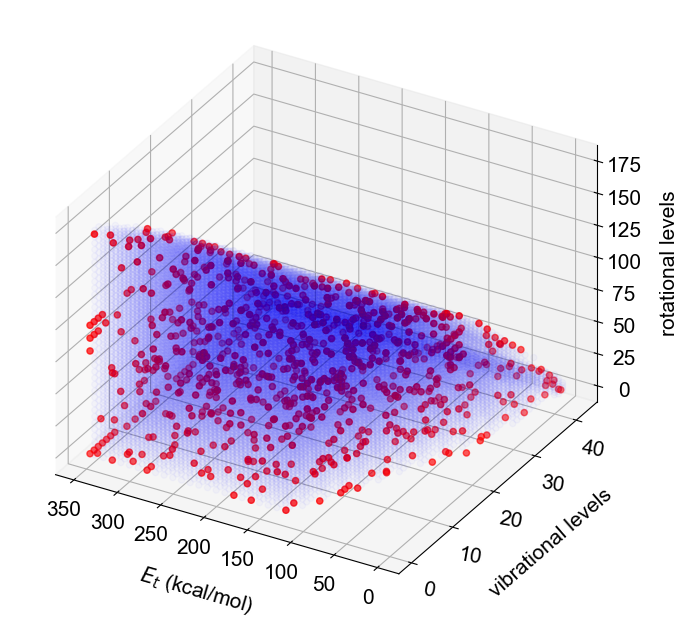

The Test set has been generated!


In [3]:
#get test set
#######################################################################################
#######################################################################################
####                                                                               ####
####                                Test set maker                                 ####
####                                                                               ####
#######################################################################################
#######################################################################################

result_list = []

data = pd.read_csv('O2-NJ.csv')

n_num = int(input("Please enter the maximum vibrational quantum number: "))

for n in range(0,n_num+1,1):
    k = str(n)
    x = data.loc[:,k].dropna()
    j_max = x.shape[0]
    
    if n < 36:
        DJ = int(5)
    elif n < 40:
        DJ = int(5)
    else:
        DJ = int(2)
    for j in range(0, j_max, DJ):
        for i in range(0,35,1):
            EN_kcal = x.iloc[j]
            Et = i*10 + 0.4
            if Et + EN_kcal > 120.2:
                result_list.append((Et, n, j))

all_results = np.vstack(result_list)

# write the data to CSV
with open('TESTSET-sample.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Et','n','j'])
    csvwriter.writerows(result_list)

# write the data to TXT
with open('dataplot', 'w') as file:
    for row in result_list:
        file.write(f"{row[0]:.1f} {row[1]} {row[2]}\n")

delics = pd.read_csv("ICS-output.csv", delimiter=",", header=None)
x_ics = delics.iloc[:, 0]
y_ics = delics.iloc[:, 1]
z_ics = delics.iloc[:, 2]

fig = plt.figure(figsize=(8, 8))
plt.rcParams['font.family'] = 'Arial'
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

ax.scatter(all_results[:, 0], all_results[:, 1], all_results[:, 2], c='b', marker='o',alpha=0.025)
ax.scatter(x_ics, y_ics, z_ics, c='r', marker='o', zorder = 10)
ax.set_xlabel('${E_t}$ (kcal/mol)', fontsize=15, labelpad=15)
plt.gca().invert_xaxis()
ax.set_ylabel('vibrational levels', fontsize=15, labelpad=15)
ax.set_zlabel('rotational levels', fontsize=15, labelpad=10)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15, rotation=-10)
plt.tick_params(axis='z', labelsize=15) 

plt.savefig('Fig-all.png', dpi=600, bbox_inches='tight')
plt.show()

print('The Test set has been generated!')

In [9]:
# Execute the MATLAB script (python == 3.9)
#######################################################################################
#######################################################################################
####                                                                               ####
####                              GPR model MATLAB                                 ####
####                                                                               ####
#######################################################################################
#######################################################################################

# Start MATLAB
eng = matlab.engine.start_matlab()

# Execute MATLAB script
eng.eval('GPR_ICS', nargout=0)

# Close MATLAB
eng.quit()
print('MATLAB script execution ends!')

MATLAB script execution ends!


In [4]:
# output.ics1, additions based on covariance values of predicted values 
# initial conditions written to array.txt
#######################################################################################
#######################################################################################
####                                                                               ####
####                            Additional new data                                ####
####                                                                               ####
#######################################################################################
#######################################################################################

sta = float(input("The maximum covariance value: "))

data = pd.read_csv('output.ics1', sep='\s+', header=None)
filtered_data = data[data.iloc[:, -1] > sta]
print(len(filtered_data))

sample = int(input("The number of sampling: "))
sampled_data = filtered_data.sample(n=sample, random_state=1)
array_data = sampled_data.iloc[:, :3]

output_txt_filename = 'array.txt'
with open(output_txt_filename, 'w') as f:
    for row in array_data.itertuples(index=False):
        f.write(f"{row[0]:.1f} {int(row[1])} {int(row[2])}\n")
print('The array.txt has been generated!')

try:
    kl_gp_data = pd.read_csv('KL-GP.txt', sep='\s+', header=None)
    file_exists = True
except FileNotFoundError:
    kl_gp_data = pd.DataFrame()
    file_exists = False

new_data = data.iloc[:, -2:]

if file_exists:
    user_input = input("KL-GP.txt file already exists, whether to merge data? (yes/no): ")
    if user_input.strip().lower() == 'yes':
        new_data = pd.concat([kl_gp_data, new_data.reset_index(drop=True)], axis=1)
        new_data.to_csv('KL-GP.txt', sep=' ', header=False, index=False)
        print('The KL-GP.txt has been generated!')
    else:
        print("Don't merge data.")
else:
    new_data = new_data.reset_index(drop=True)
    new_data.to_csv('KL-GP.txt', sep=' ', header=False, index=False)
    print('The KL-GP.txt has been generated!')

109
The array.txt has been generated!
The KL-GP.txt has been generated!


Call the VENUS code, read the array.txt obtained from the complementary sampling, and execute the automatic bmax measurement task.
Generate the array-bmax.txt file after the test, and then execute the trajectory calculation task.
Get the file to record ICS data: deltv1ics.
Splice it with the initial training set, and then train the GPR model to get the new predicted values and covariance values.

In [ ]:
# calculate the KL Divergence
#######################################################################################
#######################################################################################
####                                                                               ####
####                           GPR models KL Divergence                            ####
####                                                                               ####
#######################################################################################
#######################################################################################

# read data
data = np.loadtxt("KL-GP.txt", usecols=(-4, -3, -2, -1))

def kl_divergence(mu1, Sigma1, mu2, Sigma2):
    n = mu1.shape[0]
    Sigma2_inv = np.linalg.inv(Sigma2)
    diff = np.abs(mu2 - mu1) 
    kl_div = 0.5 * (np.trace(np.dot(Sigma2_inv, Sigma1))
                   + np.dot(diff.T, np.dot(Sigma2_inv, diff))
                   - n + np.log(np.linalg.det(Sigma2) / np.linalg.det(Sigma1)))
    return kl_div

m = data.shape[0]

kl_div_list = []  
for i in range(m):
    mu1, Sigma1, mu2, Sigma2 = data[i]
    mu1 = np.array([mu1])
    mu2 = np.array([mu2])
    Sigma1 = np.array([[Sigma1]])
    Sigma2 = np.array([[Sigma2]])
    kl_div = kl_divergence(mu1, Sigma1, mu2, Sigma2)
    kl_div_list.append(kl_div)
    print("The KL divergence in row {} is {:.2f}".format(i+1, kl_div))

kl_div_arr = np.array(kl_div_list)
np.savetxt('KL-GP-out-13.csv', kl_div_arr, delimiter=',', fmt='%.2f')

print("The sum of the KL divergence for all rows is {:.2f}".format(np.sum(kl_div_arr)))

Once the KL divergence is sufficiently small and the fluctuations are also small, the validation set is sampled using the LHS (without overlapping with the training set), and the ICS is predicted using the GPR model, which is substituted with the ICS computed directly by the QCT to compute the MSE and R2 values using the following procedure.

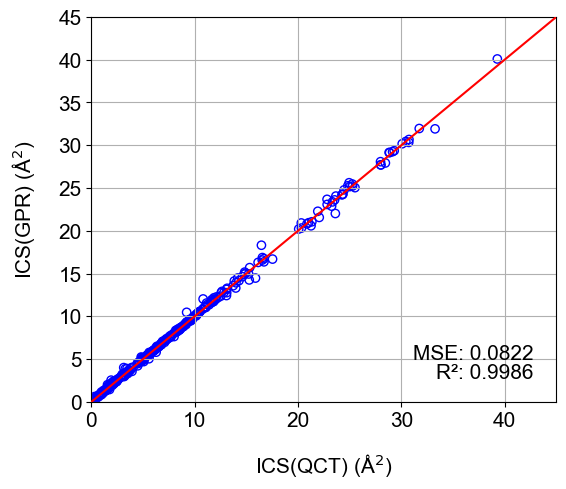

MSE: 0.0822
R²: 0.9986


In [2]:
# Calculate MSE and R^2 (measure of fit)
#######################################################################################
#######################################################################################
####                                                                               ####
####                                 MSE AND R^2                                   ####
####                                                                               ####
#######################################################################################
#######################################################################################

data = pd.read_csv('GPR_data.csv')
x = data.loc[:,'QCT']
y = data.loc[:,'GPR']

x_e = np.arange(-10, 50, 1)
y_e = x_e

fig = plt.figure(figsize=(6, 5))

plt.rcParams['font.family'] = 'Arial'
#plt.scatter(x, y, color='b')
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='b')
plt.plot(x_e, y_e, color='r', zorder = 10)

plt.xlim(0, 45)
plt.ylim(0, 45)

plt.xlabel('ICS(QCT) (Å${^2}$)',fontsize=15, labelpad=15)
plt.ylabel('ICS(GPR) (Å${^2}$)',fontsize=15, labelpad=15)

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.grid(True)

MSE = mean_squared_error(x,y)
R2 = r2_score(x,y)

plt.text(0.95, 0.15, "MSE: {:.4f}".format(MSE),
         horizontalalignment='right',
         verticalalignment='top',
         transform=plt.gca().transAxes,
         fontsize=15)

# add label
plt.text(0.95, 0.10, "R\u00B2: {:.4f}".format(R2),
         horizontalalignment='right',
         verticalalignment='top',
         transform=plt.gca().transAxes,
         fontsize=15)

plt.savefig('Fig-GPRQCT.png', dpi=600, bbox_inches='tight')
plt.show()

print("MSE: {:.4f}".format(MSE))
print("R\u00B2: {:.4f}".format(R2))

At the Tv = 1000 K and the T = 1000 K, the two-temperature rate coefficient (kD) = 4.69e-34 cm3/s
At the Tv = 1000 K and the T = 2000 K, the two-temperature rate coefficient (kD) = 4.49e-23 cm3/s
At the Tv = 1000 K and the T = 3000 K, the two-temperature rate coefficient (kD) = 1.27e-18 cm3/s
At the Tv = 1000 K and the T = 4000 K, the two-temperature rate coefficient (kD) = 2.46e-16 cm3/s
At the Tv = 1000 K and the T = 5000 K, the two-temperature rate coefficient (kD) = 6.14e-15 cm3/s
At the Tv = 1000 K and the T = 6000 K, the two-temperature rate coefficient (kD) = 5.40e-14 cm3/s
At the Tv = 1000 K and the T = 7000 K, the two-temperature rate coefficient (kD) = 2.60e-13 cm3/s
At the Tv = 1000 K and the T = 8000 K, the two-temperature rate coefficient (kD) = 8.53e-13 cm3/s
At the Tv = 1000 K and the T = 9000 K, the two-temperature rate coefficient (kD) = 2.17e-12 cm3/s
At the Tv = 1000 K and the T = 10000 K, the two-temperature rate coefficient (kD) = 4.61e-12 cm3/s
At the Tv = 2000 K 

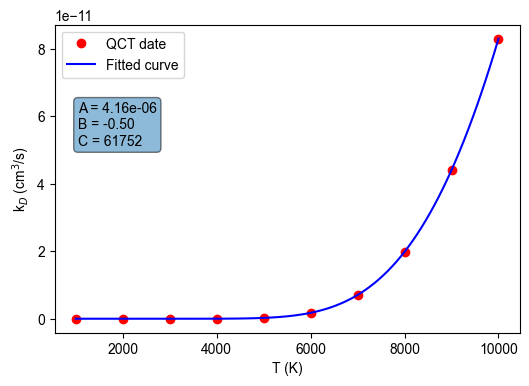

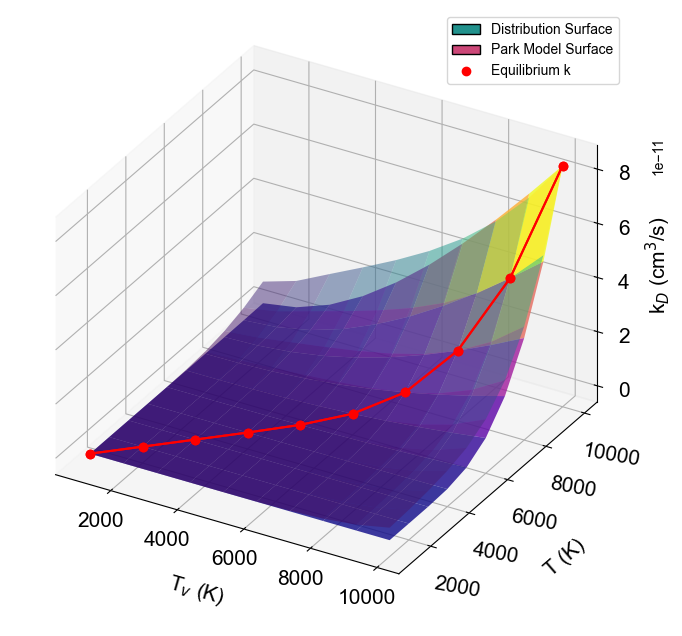

In [10]:
# TWO-TEMPERATURE-MODEL
#######################################################################################
#######################################################################################
####                                                                               ####
####                            TWO-TEMPERATURE-MODEL                              ####
####                                                                               ####
#######################################################################################
#######################################################################################

# conversion of units: J = N·m = kg·m/s^2·m

h = 6.626e-34                 # unit：J·s
Na = 6.022e23                 # unit：mol-1
kb = 1.38e-23                 # unit：J/K
a = 1588.8                    # unit：cm-1
v = a*29.978e9                # unit：Hz or s^-1
m1 = ((15.99491*2)*0.001)/Na  # unit：kg
m2 = (15.99491*0.001)/Na      # unit：kg
M = (m1*m2)/(m1+m2)           # unit：kg
I = 0.5*m2*(1.208e-10)**2     # unit：kg*m²
N_min = 0
N_max = 0
J_min = 0
J_max = 0
DN = 0
DJ = 0
DE = 0

data = pd.read_csv('O2-NJ.csv')
keys = data.columns
values = data.iloc[0]
DN = len(keys)
N_max = DN - 1
EN_kcal_dict = {i: values.iloc[i] for i in range(len(keys))}
J_MAX_dict = {i: data.iloc[:, i].notna().sum() for i in range(len(keys))}

# vibrational quantum number distribution
def TV_N(N, Tv):
    N_Z = np.linspace(N_min, N_max, DN)
    EN_Z_kcal = np.array([EN_kcal_dict[int(n)] for n in N_Z])
    EN_Z_j = EN_Z_kcal*4184/Na
    Z = np.sum(np.exp(-EN_Z_j / (kb * Tv))) 
    EN_kcal = EN_kcal_dict.get(N)
    EN_j = EN_kcal*4184/Na
    Q_v = np.exp(-EN_j / (kb*Tv))
    P_v = Q_v/Z
    return P_v

# rotational quantum number distribution
def T_J(J, T):
    J_Z = np.linspace(J_min, J_max, DJ)
    Z = np.sum((2*J_Z + 1) * np.exp(- J_Z * (J_Z + 1) * h**2 / (8 * I * kb * T * math.pi**2)))
    P_J = ((2*J + 1) * np.exp(- J * (J + 1) * h**2 / (8 * I * kb * T * math.pi**2))) / Z 
    return P_J

# Maxwell distribution (using collision energy)
def k_Et_ini(Et, sigma, T):
    Et_j = Et*4184/Na # unit: J
    c = np.sqrt(2*Et_j/M)
    deltE = DE*4184/Na # unit: J
    probabilities = (2/(np.pi**0.5)) * ((1/(kb*T))**1.5) * (Et_j**0.5) * np.exp(-Et_j / (kb * T)) * deltE
    k_Et = 16/3 * c * probabilities * (sigma * 1e-16) * 100  # unit: cm^3·s^-1 ps：the unit of c need be cm/s
    return k_Et

def gen_Tv_values():
    Tv_range = input("Please enter the range of Tv (min-max): ")
    T_min, T_max = map(int, Tv_range.split('-'))
    step = int(input("Please enter the step of Tv: "))
    Tv_val = list(range(T_min, T_max + step, step))
    return Tv_val

def gen_T_values():
    T_range = input("Please enter the range of T (min-max): ")
    T_min, T_max = map(int, T_range.split('-'))
    step = int(input("Please enter the step of T: "))
    T_val = list(range(T_min, T_max + step, step))
    return T_val

Tv_values = gen_Tv_values()
T_values = gen_T_values()
DE = float(input("Please enter the step of collision energy (kcal/mol): "))

total_sum_values = []

for Tv in Tv_values:
    row_values = []
    for T in T_values:
        total_sum = 0
        input_file = 'output.ics1'
        filtered_lines = []
        with open(input_file, 'r') as infile:
            for line in infile:
                values = line.split() 
                sigma = float(values[3])
                if sigma > 0:
                    filtered_lines.append(line)

        for line in filtered_lines:
            values = line.split()
            Et = float(f"{float(values[0]):.1f}")
            N = float(values[1])
            N = int(N)
            J = float(values[2])
            J = int(J)
            sigma = float(f"{float(values[3]):.2f}")

            if N < 36:
                J_max = J_MAX_dict.get(N)//10*10
                DJ = int(J_max/10 + 1)
            elif N < 40:
                J_max = J_MAX_dict.get(N)//5*5
                DJ = int(J_max/5 + 1)
            else:
                J_max = J_MAX_dict.get(N)//2*2
                DJ = int(J_max/2 + 1)

            kini = k_Et_ini(Et, sigma, T)
            Pn = TV_N(N, Tv)
            Pj = T_J(J, T)
            total_sum += 2*kini*Pn*Pj
            
        row_values.append(total_sum)
    total_sum_values.append(row_values)

# Write data to CSV file
with open("kD-2T.csv", "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Tv", "T", "total_sum"])
    for i in range(len(Tv_values)):
        for j in range(len(T_values)):
            Tv = Tv_values[i]
            T = T_values[j]
            total_sum = total_sum_values[i][j]
            output_str = "At the Tv = {} K and the T = {} K, the two-temperature rate coefficient (kD) = {:.2e} cm3/s\n".format(Tv, T, total_sum)
            print(output_str.strip())
            writer.writerow([Tv, T, total_sum])

# read the data in CSV file
data = np.loadtxt("kD-2T.csv", delimiter=",", skiprows=1)
Tv_data = data[:, 0]
T_data = data[:, 1]
total_sum_data = data[:, 2]

Tv_grid, T_grid = np.meshgrid(Tv_values, T_values)
total_sum_grid = total_sum_data.reshape(len(Tv_values), len(T_values))
equal_points = np.where(Tv_grid == T_grid)

x_equal = Tv_grid[equal_points]
y_equal = T_grid[equal_points]
z_equal = total_sum_grid[equal_points]

##################fit the Arrhenius equation########################################

# three-parameter Aresenius formula： k = A*(T^B)*exp(-C/T)
def arrhenius_three(T, A, B, C):
    return A * (T ** B) * np.exp(-C / T)

# Fitting to k data at T = Tv
T_fit = x_equal

# Setting up initial guesses for A, B, and C
popt, pcov = curve_fit(arrhenius_three, T_fit, z_equal, p0=[6e-6, -0.8, 50000])
A_fit, B_fit, C_fit = popt

print("The fitted parameters are:")
print(f"A = {A_fit:.2e}")
print(f"B = {B_fit:.2f}")
print(f"C = {int(round(C_fit))}")

# Plotting the fitted curve
T_model = np.linspace(T_fit.min(), T_fit.max(), 100)
k_model = arrhenius_three(T_model, A_fit, B_fit, C_fit)
plt.figure(figsize=(6, 4))
plt.plot(T_fit, z_equal, 'ro', label='QCT date')
plt.plot(T_model, k_model, 'b-', label='Fitted curve')

param_text = f"A = {A_fit:.2e}\nB = {B_fit:.2f}\nC = {int(round(C_fit))}"
plt.text(0.05, 0.75, param_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.5))

plt.xlabel('T (K)')
plt.ylabel('k${_D}$ (cm${^3}$/s)')
plt.legend()
plt.show()

#####################Park model################################################

with open("Park-kD-2T.csv", "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Tv", "T", "k_Tz"])
    for i in range(len(Tv_values)):
        for j in range(len(T_values)):
            Tv = Tv_values[i]
            T = T_values[j]
            q = 0.3
            # Park model: Tz = (T^q)*(Tv^(1-q))
            Tz = (T ** q) * (Tv ** (1-q))
            k_Tz = arrhenius_three(Tz, A_fit, B_fit, C_fit)
            writer.writerow([Tv, T, k_Tz])

# read the data in CSV file
data1 = np.loadtxt("Park-kD-2T.csv", delimiter=",", skiprows=1)
Tv_data1 = data1[:, 0]
T_data1 = data1[:, 1]
k_Tz_data1 = data1[:, 2]

Tv_grid1, T_grid1 = np.meshgrid(Tv_values, T_values)
k_Tz_grid = k_Tz_data1.reshape(len(Tv_values), len(T_values))
equal_points = np.where(Tv_grid1 == T_grid1)

x_equal1 = Tv_grid1[equal_points]
y_equal1 = T_grid1[equal_points]
z_equal1 = k_Tz_grid[equal_points]

# Drawing of combined 3D surface
fig = plt.figure(figsize=(8, 8))
plt.rcParams['font.family'] = 'Arial'

ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

cmap1=cm.viridis
cmap2=cm.plasma

# First set of data
ax.plot_surface(Tv_grid, T_grid, total_sum_grid, cmap=cmap1, alpha=0.5, label="distribution")  
ax.plot(x_equal, y_equal, z_equal, color='r', marker='o', zorder=10)  

# Second set of data
ax.plot_surface(Tv_grid1, T_grid1, k_Tz_grid, cmap=cmap2, alpha=0.8, label="Park Model")
ax.plot(x_equal1, y_equal1, z_equal1, color='r', marker='o', zorder=10)  

ax.set_xlabel('T${_v}$ (K)', fontsize=15, labelpad=15)  
ax.set_ylabel('T (K)', fontsize=15, labelpad=24)  
ax.set_zlabel('k${_D}$ (cm${^3}$/s)', fontsize=15, labelpad=5)

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15, rotation=-10, pad=10)
plt.tick_params(axis='z', labelsize=15)  

color1 = cmap1(0.5)  
color2 = cmap2(0.5)  

# Add Legend
legend_elements = [
    Patch(facecolor=color1, edgecolor='black', label='Distribution Surface'),
    Patch(facecolor=color2, edgecolor='black', label='Park Model Surface'),
    Line2D([0], [0], color='red', marker='o', linestyle='', label='Equilibrium k')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.savefig('Fig-Combined-k.png', dpi=600, bbox_inches='tight')
plt.show()
